# Notebook

Objective: identifying skills keywords from job descritions with basic NLP techniques.

In [49]:
import collections
import json
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from wordcloud import WordCloud

from selenium import webdriver
from bs4 import BeautifulSoup
import time
import string
import numpy as np
import seaborn as sns
from tqdm import tqdm

## Data extraction

In [50]:
def url_to_soup(url):
    """"
    Step 1: extract url's html into soup object.
    """
    driver = webdriver.Chrome()
    driver.get(url)

    time.sleep(3)
    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")
    driver.close()
    return soup

# Check.
#url = "https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=United%20States"
#soup = url_to_soup(url)

In [51]:
def soup_to_jobs(soup):
    """"
    Step 2: get all jobs specific url from the LinkedIn general search.
    """
    descriptions = soup.find_all("a", class_="base-card__full-link absolute top-0 right-0 bottom-0 left-0 p-0 z-[2]")

    list_job_href = [i.get('href') for i in descriptions]
    print(f"Jobs found: {len(list_job_href)}")
    
    return list_job_href

# Check.
#list_job_href = soup_to_jobs(soup)

In [52]:
def jobs_to_description(list_href):
    """
    Step 3: extract raw job description from job posting.
    """
    list_title = []
    list_description = []
    
    for href in list_href:
        soup = url_to_soup(href)
        list_title.append(soup.find('title').string)
        list_description.append(soup.find('div', class_='show-more-less-html__markup show-more-less-html__markup--clamp-after-5').get_text())

    df = pd.DataFrame({'title': list_title, 'href': list_href, 'description':list_description})
    return df

# Check
#df = jobs_to_description(list_job_href[:3])

In [53]:
# Creating single list of LinkedIn job's urls passing specific filters.
df_states = pd.read_html('https://www.jagranjosh.com/general-knowledge/list-of-states-in-usa-1663078166-1', header=0)[0]
df_states['State'] = df_states['State'].str.replace(' ', '%20')


list_url = []
for i in df_states['State']:
    # Name: Senior Data Scientist.
    list_url.append(f'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location={i}&position=1&pageNum=0')

    # Experience level: mid-senior level.
    list_url.append(f'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location={i}&f_TPR=&f_E=4&position=1&pageNum=0')

    # Name: Data Scientist III
    list_url.append(f'https://www.linkedin.com/jobs/search?keywords=Data%20Scientist%20III&location={i}&position=1&pageNum=0')

list_url[:5]

['https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=Alabama&position=1&pageNum=0',
 'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=Alabama&f_TPR=&f_E=4&position=1&pageNum=0',
 'https://www.linkedin.com/jobs/search?keywords=Data%20Scientist%20III&location=Alabama&position=1&pageNum=0',
 'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=Alaska&position=1&pageNum=0',
 'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=Alaska&f_TPR=&f_E=4&position=1&pageNum=0']

In [54]:
def pipeline_extract(list_url):
    """
    Step 1 + 2 + 3: encapsulate all exctraction steps.
    """

    df_output = pd.DataFrame()
    for i in tqdm(list_url):
        try:
            soup = url_to_soup(i)
            list_job_href = soup_to_jobs(soup)
            df = jobs_to_description(list_job_href)
            df_output = pd.concat([df_output, df], axis=0).reset_index(drop=True)
        except:
            print(f"The url {i} did not return jobs.")

    df_output.drop_duplicates(inplace=True)
    return df_output

In [55]:
# Data extraction. Warning: the process takes at least 4 to 6 hours.
#df_raw = pipeline_extract(list_url)
#df_raw.to_csv('dataset.csv', index=False)

# Using data from previous extractions.
df_raw = pd.read_csv('dataset.csv')
df_raw.head(3)

,title,href,description
0,Recruiting from Scratch está contratando Senio...,https://www.linkedin.com/jobs/view/senior-data...,\nWho is Recruiting from Scratch: Recruiting f...
1,Recruiting from Scratch está contratando Senio...,https://www.linkedin.com/jobs/view/senior-data...,\nWho is Recruiting from Scratch: Recruiting f...
2,Intuitive Research and Technology Corporation ...,https://www.linkedin.com/jobs/view/entry-level...,\nINTUITIVE® is a nationally recognized Best P...


In [56]:
# Creating single list of LinkedIn job's urls passing specific filters.
df_states = pd.read_html('https://www.jagranjosh.com/general-knowledge/list-of-states-in-usa-1663078166-1', header=0)[0]
df_states['State'] = df_states['State'].str.replace(' ', '%20')


list_url = []
for i in df_states['State']:
    # Name: Senior Data Scientist.
    list_url.append(f'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location={i}&position=1&pageNum=0')

    # Experience level: mid-senior level.
    list_url.append(f'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location={i}&f_TPR=&f_E=4&position=1&pageNum=0')

    # Name: Data Scientist III
    list_url.append(f'https://www.linkedin.com/jobs/search?keywords=Data%20Scientist%20III&location={i}&position=1&pageNum=0')

list_url[:5]

['https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=Alabama&position=1&pageNum=0',
 'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=Alabama&f_TPR=&f_E=4&position=1&pageNum=0',
 'https://www.linkedin.com/jobs/search?keywords=Data%20Scientist%20III&location=Alabama&position=1&pageNum=0',
 'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=Alaska&position=1&pageNum=0',
 'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=Alaska&f_TPR=&f_E=4&position=1&pageNum=0']

In [57]:
# Which words are the most frequent on the raw base?
long_string = ' '.join(list(df_raw['description']))
display(long_string[:100])

raw_tokens = long_string.split()
freq = collections.Counter(raw_tokens)
freq.most_common()[:30]

'\nWho is Recruiting from Scratch: Recruiting from Scratch is a premier talent firm that focuses on pl'

[('and', 80659),
 ('to', 44092),
 ('the', 34074),
 ('of', 33897),
 ('in', 24249),
 ('a', 23902),
 ('with', 18472),
 ('for', 15317),
 ('or', 13844),
 ('data', 12968),
 ('is', 11658),
 ('as', 8661),
 ('on', 7868),
 ('our', 7775),
 ('be', 7502),
 ('will', 7027),
 ('are', 6544),
 ('that', 6502),
 ('an', 6469),
 ('work', 6175),
 ('experience', 5827),
 ('business', 4716),
 ('team', 4496),
 ('you', 4485),
 ('by', 4377),
 ('at', 4353),
 ('Data', 3837),
 ('We', 3589),
 ('from', 3582),
 ('we', 3465)]

The most frequent terms of the raw data disconsidering stopwords are:
- data (12968)
- work (6175)
- experience (5827)

These words are common in job descriptions, but don't indicate skill's keywords. Data manipulation will be required.

## Data preprocessing

In [58]:
df_eda = df_raw.copy(deep=True)

In [59]:
def nlp_preprocessing(descr, stopwords, lem):

    # Specific case: "/"
    descr = descr.replace('/', ' ')

    # Tokenize description column.
    tokens = nltk.tokenize.word_tokenize(descr)

    # Lowercase all tokens.
    tokens = [i.lower() for i in tokens]

    # Remove punctuation.
    tokens = [i for i in tokens if i not in string.punctuation + '’' + '--' + '“']

    # Using nltk default stopwords.
    #nltk.download('stopwords')
    tokens = [i for i in tokens if not i in stopwords]

    # Stemming
    ps = nltk.stem.SnowballStemmer(language='english')
    #tokens = [ps.stem(i) for i in tokens]
    # obs: stemming was not useful, since it words suffixes were lost (e.g. innovation -> innov)

    # Lemmatization
    #nltk.download('wordnet')
    tokens = [lem.lemmatize(i) for i in tokens]

    # Apply corrections within dict.
    with open('dict.json', 'r') as f:
        custom_dict = json.load(f)
    
    for i in custom_dict:
        temp = []
        for j in tokens:
            temp.append(j.replace(i, custom_dict[i]))
    tokens = temp

    # Removing context relevant stopwords.
    list_custom_words = pd.read_csv('advanced_stopwords.csv', header=None, index_col=False).iloc[:, 0].tolist()
    tokens = [i for i in tokens if not i in list_custom_words]

    return tokens

In [60]:
# Preprocessing each job description composing a new column: tokens
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

nltk.download('wordnet')
lem = nltk.stem.WordNetLemmatizer()

df_eda['tokens'] = None

for index, row in tqdm(df_eda.iterrows(), total=df_eda.shape[0]):
    df_eda.at[index, 'tokens'] = nlp_preprocessing(row['description'], stopwords, lem)

df_eda.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kenji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kenji\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 2336/2336 [00:12<00:00, 192.83it/s]


,title,href,description,tokens
0,Recruiting from Scratch está contratando Senio...,https://www.linkedin.com/jobs/view/senior-data...,\nWho is Recruiting from Scratch: Recruiting f...,"[placing, manager, software, hardware, innovat..."
1,Recruiting from Scratch está contratando Senio...,https://www.linkedin.com/jobs/view/senior-data...,\nWho is Recruiting from Scratch: Recruiting f...,"[placing, manager, software, hardware, innovat..."
2,Intuitive Research and Technology Corporation ...,https://www.linkedin.com/jobs/view/entry-level...,\nINTUITIVE® is a nationally recognized Best P...,"[intuitive®, nationally, recognized, place, pr..."
3,Ignitec Inc está contratando Data Scientist em...,https://www.linkedin.com/jobs/view/data-scient...,"\nRole: Data Scientist Pay: $110,000-$130,000L...","[data, scientist, pay, 110,000-, 130,000locati..."
4,ISSAC LLC está contratando Data Scientist em: ...,https://www.linkedin.com/jobs/view/data-scient...,\n Category: Engineering Location: Hunt...,"[category, engineering, location, huntsville, ..."


In [61]:
# Just to be sure, let's filter the data: return only jobs with 'data science' or 'data scientist' in the description.
cond = [
    ('data', 'science'), 
    ('data', 'scientist'), 
    ('machine', 'learning')
    ]

# Creating bigram (it will be used later too).
df_eda['bigrams'] = None
df_eda['data_science'] = None
for index, value in tqdm(enumerate(df_eda['tokens'])):
    list_bigrams = list(nltk.ngrams(value, 2))
    df_eda.at[index, 'bigrams'] = list_bigrams

    if set(list_bigrams).intersection(cond) == set():
        result = 0
    else:
        result = 1

    df_eda.at[index, 'data_science'] = result

df_eda['data_science'].value_counts()

2336it [00:00, 22247.51it/s]


1    1461
0     875
Name: data_science, dtype: int64

In [62]:
# Example of job description with data science
df_eda.loc[df_eda['data_science'] == 1, 'description'].sample(5).iloc[0]

'\nOur Client is a dynamic global technology company and its success has been a result of its entrepreneurial spirit and long history of private ownership. As a partner to all of the major automobile manufacturers, as well as key players in the aerospace and industrial sectors, they offer you many development opportunities.This is an onsite position. There are three different locations to work from:Fort Mill, SCWooster, OHTroy, MIYour Key Responsibilities• Lead discovery processes with business stakeholders to identify opportunities and business problems and framing them into an IT data science/ advanced data analytics project initiative.• Identification and extraction of available and relevant data from internal and external data sources to perform data science solution development.• Perform data cleansing using data processing and statistical software packages.• Perform data quality assessments and statistical testing to verify data quality and data integrity• Exploratory data analys

In [63]:
# Example of job description without data science
df_eda.loc[df_eda['data_science'] == 0, 'description'].sample(5).iloc[0]

"\n        POSITION INFORMATIONOverall Position Summary and Objectives The position will independently provide support services to satisfy the overall operational objectives.Minimum EducationMaster'sResume Max Pages15Additional QualificationsCertifications & LicensesPh.D. in a scientific field and two years experienceSkills (Ranked By Priority)Collect experimental data via in vivo electrophysiology or in vivo optical imaging (2-photon calcium imaging, miniscope imaging, or fiber photometry), generate analysis codes for acquired large data sets using Matlab or Python; Provide preliminary descriptive analysis of study materials and methods.Perform behavioral tests and training of mice prior to and during data collection.; Perform animal surgical procedures for optical imaging, physiology experiments and viral injection; Prepare draft written description of the analysis procedures, findings, limitations, and the proposal for follow-up experiments.Familiarity with molecular, genetic and an

In [64]:
df_eda = df_eda.loc[df_eda['data_science'] == 1].reset_index(drop=True)
df_eda.shape

(1461, 6)

Filtering 'data science' jobs

Even after using native filter, our dataset contains 875 jobs not related to Data Science (37% sample).

## Analysis

In [65]:
df_eda.head(3)

,title,href,description,tokens,bigrams,data_science
0,Recruiting from Scratch está contratando Senio...,https://www.linkedin.com/jobs/view/senior-data...,\nWho is Recruiting from Scratch: Recruiting f...,"[placing, manager, software, hardware, innovat...","[(placing, manager), (manager, software), (sof...",1
1,Recruiting from Scratch está contratando Senio...,https://www.linkedin.com/jobs/view/senior-data...,\nWho is Recruiting from Scratch: Recruiting f...,"[placing, manager, software, hardware, innovat...","[(placing, manager), (manager, software), (sof...",1
2,Intuitive Research and Technology Corporation ...,https://www.linkedin.com/jobs/view/entry-level...,\nINTUITIVE® is a nationally recognized Best P...,"[intuitive®, nationally, recognized, place, pr...","[(intuitive®, nationally), (nationally, recogn...",1


### Frequency

In [66]:
def single_list(array):
    output = []
    for i in array:
        output+=i
    return output

In [67]:
# Checking the frequency of words
all_tokens = single_list(df_eda['tokens'])

freq = collections.Counter(all_tokens)
df_freq = pd.DataFrame({'token': freq.keys(), 'qtd': freq.values()}).sort_values('qtd', ascending=False)
df_freq.head()

,token,qtd
12,data,14452
24,science,4221
177,learning,3024
61,analysis,2892
180,model,2730


[Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Plot 1: how many times a token appears?')]

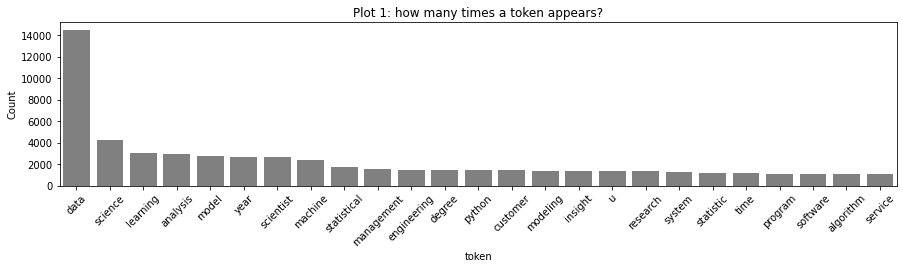

In [68]:
# Plot
plt.figure(figsize=(15, 3))
fig = sns.barplot(data=df_freq.head(25), x='token', y='qtd', color='gray')
fig.tick_params(axis='x', rotation=45)
fig.set(ylabel='Count', title='Plot 1: how many times a token appears?')

In [69]:
# Checking in how many jobs a specific term is present.
def jobs_with_token(df, term):
    qt=0
    for i in df['tokens']:
        if term in i:
            qt += 1

    freq = round(qt/df.shape[0], 2)
    return qt, freq

In [70]:
# Calculate how many jobs each token in mentioned.
df_freq['qtd_jobs'] = 0

for index, rows in tqdm(df_freq.iterrows(), total=df_freq.shape[0]):
    qtd_jobs, _ = jobs_with_token(df_eda, rows['token'])
    df_freq.at[index, 'qtd_jobs'] = qtd_jobs

df_freq = df_freq.sort_values('qtd_jobs', ascending=False)

100%|██████████| 24740/24740 [02:31<00:00, 163.45it/s]


In [71]:
# Frequency of terms by (1) number of appearances and (2) number of jobs with token.
df_freq.head(15)

,token,qtd,qtd_jobs
12,data,14452,1451
24,science,4221,1284
94,year,2672,1281
105,python,1424,1154
13,scientist,2646,1090
177,learning,3024,1067
176,machine,2358,998
61,analysis,2892,991
180,model,2730,984
92,degree,1434,960


[Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Plot 2: how many jobs contains a token?')]

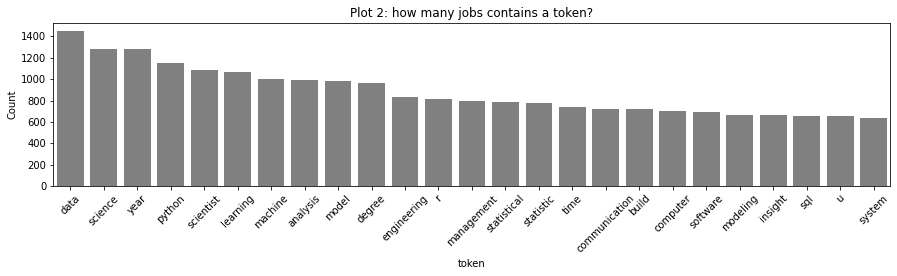

In [72]:
# Plot
plt.figure(figsize=(15, 3))
fig = sns.barplot(data=df_freq.head(25), x='token', y='qtd_jobs', color='gray')
fig.tick_params(axis='x', rotation=45)
fig.set(ylabel='Count', title='Plot 2: how many jobs contains a token?')

In [73]:
# General terms (expecting high frequency).
list_terms = ['python', 'bachelor', 'sql', 'analysis']
for i in list_terms:
    print(i, jobs_with_token(df_eda, i))

python (1154, 0.79)
bachelor (439, 0.3)
sql (660, 0.45)
analysis (991, 0.68)


In [74]:
# Specific terms (expecting moderate-low frequency)
list_terms = ['nlp', 'feature', 'selection', 'pytorch', 'kera', 'tensorflow', 'governance', 'cluster', 'storytelling']
for i in list_terms:
    print(i, jobs_with_token(df_eda, i))

nlp (153, 0.1)
feature (176, 0.12)
selection (89, 0.06)
pytorch (99, 0.07)
kera (74, 0.05)
tensorflow (168, 0.11)
governance (103, 0.07)
cluster (33, 0.02)
storytelling (11, 0.01)


### Language

In [75]:
# Comparing different languages.
list_lang = ['python', 'sql', 'r', 'java', 'c', 'go', 'julia', 'scala', 'javascript', 'swift', 'matlab', 'sas']
# obs: languages obtained from https://www.datacamp.com/blog/top-programming-languages-for-data-scientists-in-2022

df_lang = df_freq.loc[df_freq['token'].isin(list_lang)]
df_lang['perc'] = round((df_lang['qtd_jobs'] / df_eda.shape[0] * 100), 1)
df_lang = df_lang.drop(columns='qtd')
df_lang.columns=['token', 'count', 'percentage']

C:\Users\Kenji\AppData\Local\Temp\ipykernel_18312\540118872.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lang['perc'] = round((df_lang['qtd_jobs'] / df_eda.shape[0] * 100), 1)


In [76]:
# Language relevancy (frequency of jobs containing each keyword)
df_lang

,token,count,percentage
105,python,1154,79.0
106,r,814,55.7
103,sql,660,45.2
396,java,195,13.3
397,scala,156,10.7
1395,go,105,7.2
611,c,88,6.0
1770,matlab,66,4.5
606,julia,51,3.5
608,javascript,36,2.5


In [77]:
# Is there any job posting without a programming language?
df_eda['no_programming'] = np.where(df_eda['tokens'].isin(list_lang), 0, 1)
df_eda['no_programming'].value_counts()

1    1461
Name: no_programming, dtype: int64

##### python, R and sql

The majority of program language is definitely `python`, `R` and `sql`, being present in almost in 3 of 4 job postings.

### N-grams

In [79]:
# Bigram was aready created. Now creating trigrams.
df_eda['trigrams'] = None

for index, value in enumerate(df_eda['tokens']):
    list_trigrams = list(nltk.ngrams(value, 3))
    #list_trigrams = [frozenset(i) for i in list_trigrams]
    df_eda.at[index, 'trigrams'] = list_trigrams

df_eda.head(3)

,title,href,description,tokens,bigrams,data_science,no_programming,trigrams
0,Recruiting from Scratch está contratando Senio...,https://www.linkedin.com/jobs/view/senior-data...,\nWho is Recruiting from Scratch: Recruiting f...,"[placing, manager, software, hardware, innovat...","[(placing, manager), (manager, software), (sof...",1,1,"[(placing, manager, software), (manager, softw..."
1,Recruiting from Scratch está contratando Senio...,https://www.linkedin.com/jobs/view/senior-data...,\nWho is Recruiting from Scratch: Recruiting f...,"[placing, manager, software, hardware, innovat...","[(placing, manager), (manager, software), (sof...",1,1,"[(placing, manager, software), (manager, softw..."
2,Intuitive Research and Technology Corporation ...,https://www.linkedin.com/jobs/view/entry-level...,\nINTUITIVE® is a nationally recognized Best P...,"[intuitive®, nationally, recognized, place, pr...","[(intuitive®, nationally), (nationally, recogn...",1,1,"[(intuitive®, nationally, recognized), (nation..."


In [80]:
# Unifyng all bigrams and trigrams to a single list.
bigrams = single_list(df_eda['bigrams'])
trigrams = single_list(df_eda['trigrams'])

#### Bigrams

In [81]:
# Organizing the bigram
df_bi = pd.DataFrame({'bigram': bigrams}).value_counts().to_frame().reset_index().rename(columns={0:'qtd'})

list_token1 = []
list_token2 = []
for i in df_bi['bigram']:
    try:
        token1, token2 = i
        list_token1.append(token1)
        list_token2.append(token2)
    except:
        token1 = i
        list_token1.append(token1)
        list_token2.append(token1)
        
df_bi['token1'] = list_token1
df_bi['token2'] = list_token2

In [82]:
df_bi.describe(percentiles=np.array(list(range(1, 10, 1)))/10).T.round(1)

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
qtd,122788.0,3.4,15.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,5.0,2876.0


In [83]:
# Total number of appearances (a bigram may appear multiple times in a single job)
df_bi.head(15)

,bigram,qtd,token1,token2
0,"(data, science)",2876,data,science
1,"(machine, learning)",2222,machine,learning
2,"(data, scientist)",2100,data,scientist
3,"(computer, science)",759,computer,science
4,"(data, analysis)",548,data,analysis
5,"(python, r)",458,python,r
6,"(data, visualization)",456,data,visualization
7,"(data, set)",429,data,set
8,"(deep, learning)",380,deep,learning
9,"(bachelor, degree)",380,bachelor,degree


In [86]:
# Check ngrams frequency (how many jobs uses the ngram)
def jobs_with_ngram(df, ngram):
    if len(ngram) == 2:
        column = 'bigrams'
    else:
        column='trigrams'

    qt = 0
    for i in df[column]:
        if ngram in i:
            qt += 1
    freq = round(qt/df.shape[0], 2)
    return qt, freq

In [87]:
# Create dataframe with job frequency for each bigram existent.
df_bi['qtd_job'] = None
for index, row in tqdm(df_bi.iterrows(), total=df_bi.shape[0]):
    
    if (row['qtd'] < 100):
        # low frequency bigram: ignore calculation to speed the process.
        pass
    
    else:
        qtd_jobs, _ = jobs_with_ngram(df_eda, row['bigram'])
        df_bi.at[index, 'qtd_job'] = qtd_jobs

df_bi = df_bi.sort_values('qtd_job', ascending=False)

100%|██████████| 122788/122788 [00:03<00:00, 35478.73it/s]


In [100]:
df_bi

,bigram,qtd,token1,token2,qtd_job
0,"(data, science)",2876,data,science,1095
1,"(machine, learning)",2222,machine,learning,964
2,"(data, scientist)",2100,data,scientist,881
3,"(computer, science)",759,computer,science,605
5,"(python, r)",458,python,r,439
...,...,...,...,...,...
122783,"(next, year.a)",1,next,year.a,None
122784,"(next-gen, fintech)",1,next-gen,fintech,None
122785,"(next-gen, sequencing)",1,next-gen,sequencing,None
122786,"(next-gen, transcriptomic)",1,next-gen,transcriptomic,None


In [118]:
# Improve interpretability.
df_bigram = df_bi[['bigram', 'qtd_job']].loc[df_bi['qtd_job'].notnull()]
df_bigram.columns = ['bigrams', 'jobs_frequency']
df_bigram['percentage'] = (df_bigram['jobs_frequency'] / df_eda.shape[0] * 100).astype(float).round(1)

In [120]:
# Frequency of bigrams (number of jobs containing each bigram)
df_bigram.head(15)

,bigrams,jobs_frequency,percentage
0,"(data, science)",1095,74.9
1,"(machine, learning)",964,66.0
2,"(data, scientist)",881,60.3
3,"(computer, science)",605,41.4
5,"(python, r)",439,30.0
4,"(data, analysis)",373,25.5
6,"(data, visualization)",362,24.8
9,"(bachelor, degree)",349,23.9
10,"(master, degree)",346,23.7
11,"(year, data)",304,20.8


In [90]:
# General bigram (expecting high frequency).
list_bigrams_general = [('machine', 'learning'), ('data', 'visualization'), ('data', 'analysis')]
for i in list_bigrams_general:
    print(i, jobs_with_ngram(df_eda, i))

('machine', 'learning') (964, 0.66)
('data', 'visualization') (362, 0.25)
('data', 'analysis') (373, 0.26)


In [91]:
# Specific bigram (expecting low-moderate frequency).
list_bigrams_general = [('feature', 'engineering'), ('feature', 'selection'), ('survival', 'analysis')]
for i in list_bigrams_general:
    print(i, jobs_with_ngram(df_eda, i))

('feature', 'engineering') (41, 0.03)
('feature', 'selection') (11, 0.01)
('survival', 'analysis') (11, 0.01)


##### (machine-learning), (data-analysis)

The majority of the sample are unique bigrams (percentile 70), with the most frequent bigram appeared 209 times. This result can be perceived as a sign that we may be in the correct path; since our goal is to retrieve the most relevant bigrams, we reduces our burden in at least 70%.



### Trigram

In [92]:
# Organizing the trigram.
df_tri = pd.DataFrame({'trigram': trigrams}).value_counts().to_frame().reset_index().rename(columns={0:'qtd'})
df_tri.describe(percentiles=np.array(list(range(1, 10, 1)))/10).T.round(1)

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
qtd,156710.0,2.6,5.8,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,4.0,183.0


In [93]:
# Total number of appearances.
df_tri.head(20)

,trigram,qtd
0,"(machine, learning, model)",183
1,"(year, data, science)",181
2,"(100, management, accel)",158
3,"(software, hardware, innovative)",158
4,"(hardware, innovative, 100)",158
5,"(manager, software, hardware)",158
6,"(innovative, 100, management)",158
7,"(placing, manager, software)",158
8,"(management, accel, dfj)",158
9,"(looking, data, scientist)",156


In [95]:
# Filter only trigrams based on data.
list_index = []
for index, value in enumerate(df_eda['trigrams']):
    if 'data' in str(value):
        list_index.append(index)

temp = df_eda.loc[list_index, 'trigrams']
data_trigrams = single_list(temp)

df_data_tri = pd.DataFrame({'trigrams': data_trigrams}).value_counts().to_frame().reset_index().rename(columns={0:'qtd'})
df_data_tri.head(20)

,trigrams,qtd
0,"(machine, learning, model)",181
1,"(year, data, science)",181
2,"(manager, software, hardware)",158
3,"(hardware, innovative, 100)",158
4,"(innovative, 100, management)",158
5,"(placing, manager, software)",158
6,"(100, management, accel)",158
7,"(management, accel, dfj)",158
8,"(software, hardware, innovative)",158
9,"(looking, data, scientist)",156


In [96]:
# General trigram (expecting high frequency).
list_trigrams_general = [('machine', 'learning', 'model'), ('written', 'verbal', 'communication'), ('large', 'data', 'set'), ('quantitative', 'statistical', 'analysis'), ('statistical', 'analysis', 'regression')]
for i in list_trigrams_general:
    print(i, jobs_with_ngram(df_eda, i))

('machine', 'learning', 'model') (147, 0.1)
('written', 'verbal', 'communication') (87, 0.06)
('large', 'data', 'set') (94, 0.06)
('quantitative', 'statistical', 'analysis') (88, 0.06)
('statistical', 'analysis', 'regression') (101, 0.07)


##### (machine, learning, model)

In a superficial view, trigrams were not insightful. Although the most frequent combinations were relevant (e.g. `machine-learning-model`), there were trigrams with high frequency because of similar job posting (e.g. `placing-manager-software` from a single company called Scratch).

## Conclusion

The most relevant keywords are:

- machine learning
- data analysis
- python
- r
- bachelor's and/or master's degree
- data visualization
- deep learning
- statistical analysis
- data mining
- verbal and written communication skills

##### Insights

- Specific keywords (e.g. feature selection or feature engineering) are significantly less frequent than general keywords (e.g. machine learning, deep learning). This fact does not necessarily means that specific keywords are not relevant, just that these keywords may be more relevant in specific job positions.

- Education matters a lot! Oriented bachelor's or master's degree are frequently found in job descriptions.
